<h1>CX study</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data

from fh import flow_hierarchy
from utils import conn2adj

<h3>CX / flow_hierarchy </h3>

In [3]:
c = Client(conf.neuprint_URL, conf.dataset_version)


In [4]:
CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']

results = pd.DataFrame(data=CX_rois,columns=['primary_roi'])

#basic/local metrics
results = pd.concat([results,pd.Series([],name='number_neurons',dtype=np.int)],axis=1)
results = pd.concat([results,pd.Series([],name='number_synapses',dtype=np.int)],axis=1)
results = pd.concat([results,pd.Series([],name='indegree_mean',dtype=np.float)],axis=1)
results = pd.concat([results,pd.Series([],name='outdegree_mean',dtype=np.float)],axis=1)

# results = pd.concat([results,pd.Series([],name='katz_centrality',dtype=np.float)],axis=1)
# results = pd.concat([results,pd.Series([],name='',dtype=np.float)],axis=1)

#global metrics
results = pd.concat([results,pd.Series([],name='recurrence',dtype=np.float)],axis=1)
results = pd.concat([results,pd.Series([],name='flow_hierarchy',dtype=np.float)],axis=1)


In [5]:
results_fh_cols = ['fh','fh_randomwire_mean','fh_randomwire_std','fh_randomweight_mean','fh_randomweight_std']
results_fh = pd.DataFrame(data=CX_rois,columns=['primary_roi'])
for col in results_fh_cols:
    results_fh = pd.concat([results_fh,pd.Series([],name=col,dtype=np.float)],axis=1)

In [6]:
#load flow_hierarchy
for i,rec in results.iterrows():
    try:
        roi = rec['primary_roi']
        #print(roi)
        path = os.path.join(conf.results_dir,'primary_roi_fh','roi='+roi+'.txt')
        if os.path.exists(path):
            #print(roi,'result found')
            with open(path,'r') as f:
                s = f.read()
                h,h_randwire_mean,h_randwire_std,h_randweight_mean,h_randweight_std = list(map(float,s.split(' ')))
                results.loc[results['primary_roi']==roi,'flow_hierarchy'] = h
                
                results_fh.loc[results_fh['primary_roi']==roi,'fh'] = h
                results_fh.loc[results_fh['primary_roi']==roi,'fh_randomwire_mean'] = h_randwire_mean
                results_fh.loc[results_fh['primary_roi']==roi,'fh_randomwire_std'] = h_randwire_std
                results_fh.loc[results_fh['primary_roi']==roi,'fh_randomweight_mean'] = h_randweight_mean
                results_fh.loc[results_fh['primary_roi']==roi,'fh_randomweight_std'] = h_randweight_std
        #else:
            #print(roi,'result NOT found')
    except MemoryError:
        print('memory error')
        continue



In [7]:
results_fh

,primary_roi,fh,fh_randomwire_mean,fh_randomwire_std,fh_randomweight_mean,fh_randomweight_std
0,PB,0.249883,0.527204,0.031262,0.295269,0.005085
1,NO,0.018481,0.070809,0.013910,0.028451,0.002688
2,FB,0.015989,0.071464,0.005342,0.027648,0.000583
3,EB,0.004611,0.177719,0.015812,0.012787,0.000557
4,AB(L),0.104371,0.419273,0.064923,0.158647,0.005605
5,AB(R),0.071197,0.362465,0.041346,0.131202,0.004660


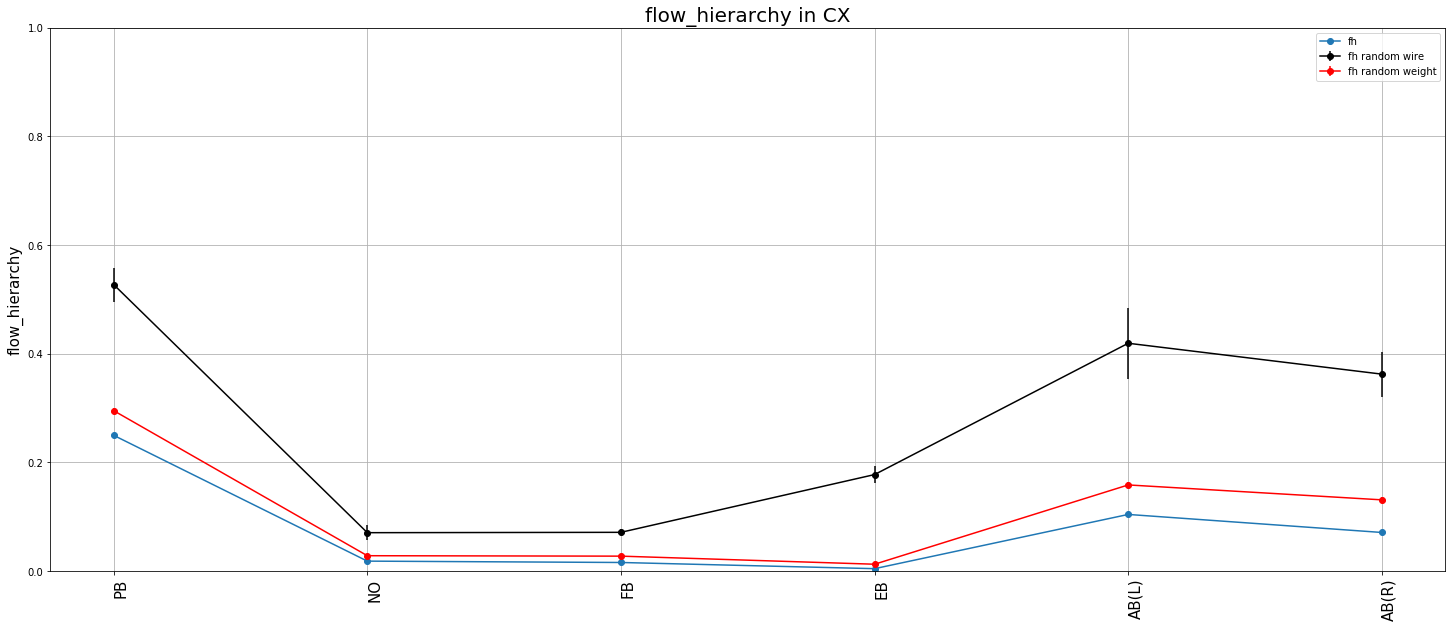

In [76]:
#plot flow_hierarchy


res_sub = results_fh[results_fh['primary_roi'].isin(CX_rois)]
#plot_list = ['all_rois','df_rois','primary_rois','toplevel_rois','nonhierarchy_rois']
fig = plt.figure(figsize=(25,10))
#t = rois[plot_list].to_numpy()
#plt.imshow(t,cmap='gray')
plt.plot(res_sub['fh'].values,'o-',label='fh')
xs = [i for i in range(res_sub.shape[0])]
plt.errorbar(x=xs,y=res_sub['fh_randomwire_mean'],yerr=res_sub['fh_randomwire_std'],fmt='ko-',label='fh random wire')
plt.errorbar(x=xs,y=res_sub['fh_randomweight_mean'],yerr=res_sub['fh_randomweight_std'],fmt='ro-',label='fh random weight')
ax = fig._get_axes()[0]
ax.grid(b=True)
# for i in range(len(rois['combined_rois'])):
#     ax.axhline(float(i)+0.5, linestyle=':', color='k',linewidth=1)
# for i in range(5):
#     ax.axvline(float(i)+0.5, linestyle=':', color='k',linewidth=1)
# ax.set_aspect(1/5)
ax.set_ylabel('flow_hierarchy',fontsize=15)
ax.set_title('flow_hierarchy in CX',fontsize=20)
ax.set_xticks(xs)
ax.set_xticklabels(res_sub['primary_roi'],fontsize=15)
ax.set_ylim(0,1)
# ax.set_xticklabels([0]+plot_list,fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
plt.legend()
plt.show()

<h3>CX / with threshold</h3>

In [9]:
CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
ths = [0,1,2,3,4,5,6,7,8,9,10,12,14,18,22,25,30,35,45,55,70,90,110]


In [10]:
def get_flow_hierarchy(rois,ths):
    hs = {roi:[] for roi in rois}
    ths_loc = {roi:[] for roi in rois}

    for roi in rois:
        for th in ths:
            path = os.path.join(conf.results_dir,'CX_study_th',f'th={th};roi={roi}.txt')
            if os.path.exists(path):
                with open(path,'r') as f:
                    res = f.read()
                    h,th = list(map(float,res.split(' ')))
                    hs[roi] += [h]
                    ths_loc[roi] += [th]
            else:
                hs[roi] += []
                ths_loc[roi] += []
                
    return hs,ths_loc

hs,ths_loc = get_flow_hierarchy(CX_rois,ths)

In [104]:
synapses = {roi:[] for roi in CX_rois}
neurons = {roi:[] for roi in CX_rois}
ths_neurons_synapses = {roi:[] for roi in CX_rois}

for roi in CX_rois:
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi)
    for th in ths:
        #print(th,roi)
        temp = conn[conn['weight']>th]
        synapses[roi] += [temp.shape[0]]
        neurons[roi] += [len(set(np.concatenate([temp['bodyId_pre'].unique(),temp['bodyId_post'].unique()])))]
        ths_neurons_synapses[roi] += [th]

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(L)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(R)
dataset already downloaded


<h3>CX / weight distributions</h3>

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(L)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(R)
dataset already downloaded


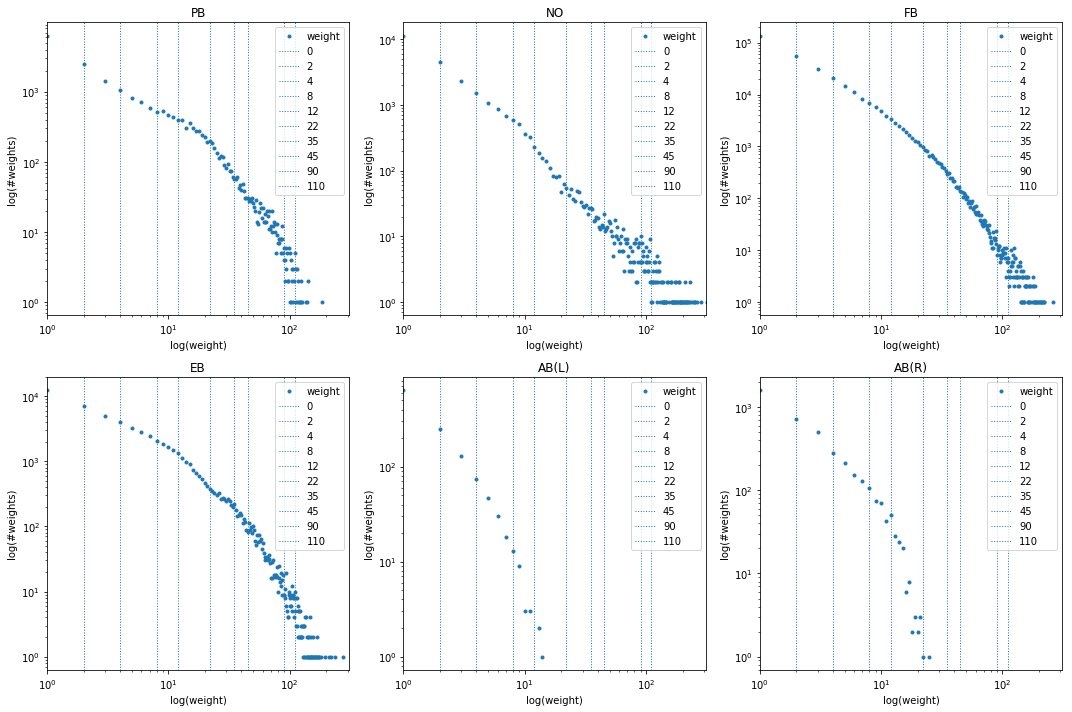

In [117]:
ths_probe = [0,2,4,8,12,22,35,45,90,110]

fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(15,10))
axs = axs.reshape(-1)
for i,roi in enumerate(CX_rois):
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi)
    

    #print(th,roi)
    #temp = conn[conn['weight']>th]
    axs[i].plot(conn['weight'].value_counts(),'.')
    axs[i].set_title(roi)
    axs[i].set_ylabel('log(#weights)')
    axs[i].set_xlabel('log(weight)')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlim(ths[1],ths[-1]+200)
    for th in ths_probe:
        axs[i].axvline(th,linestyle=':',linewidth=1,label=th)
    axs[i].legend()
        
plt.tight_layout()
plt.show()

<h3>CX / flow hierarchy vs. weight threshold</h3>

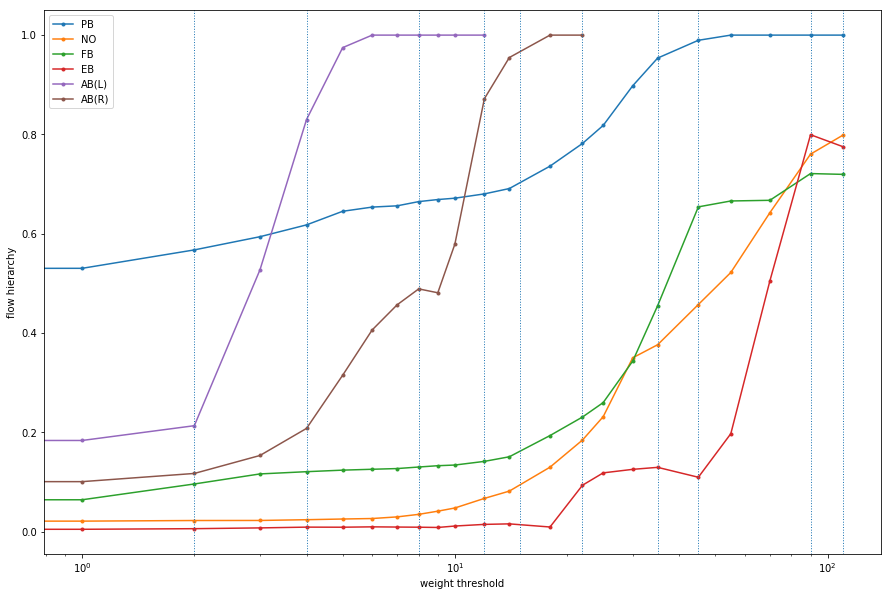

In [129]:

fig = plt.figure(figsize=(15,10))
for roi in hs.keys():
    plt.plot(ths_loc[roi],hs[roi],'.-',label=roi)
plt.legend()
plt.ylabel('flow hierarchy')
plt.xlabel('weight threshold')
plt.xscale('log')
for th in ths_probe:
    plt.axvline(th,linestyle=':',linewidth=1,label=th)
plt.show()

<h3>CX / number of synapses vs. threshold</h3>

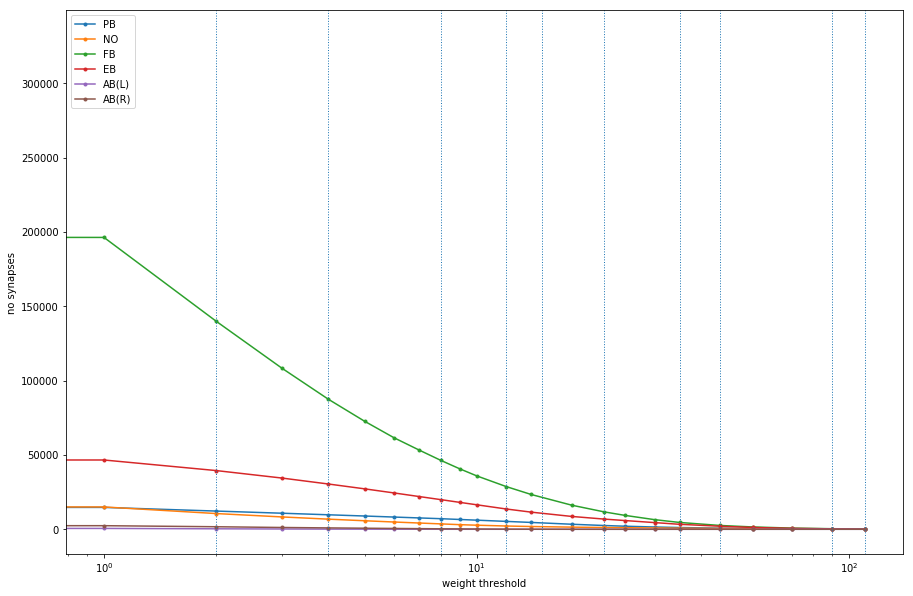

In [130]:

fig = plt.figure(figsize=(15,10))
for roi in hs.keys():
    plt.plot(ths_neurons_synapses[roi],synapses[roi],'.-',label=roi)
plt.legend()
plt.ylabel('no synapses')
plt.xlabel('weight threshold')
plt.xscale('log')
for th in ths_probe:
    plt.axvline(th,linestyle=':',linewidth=1,label=th)
plt.show()

<h3>CX / number of neurons vs. threshold</h3>

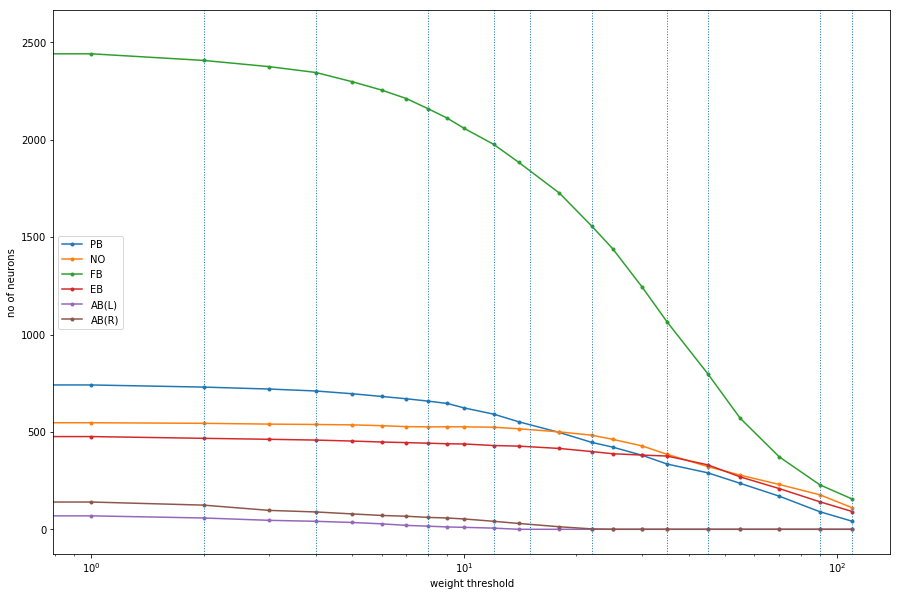

In [131]:

fig = plt.figure(figsize=(15,10))
for roi in hs.keys():
    plt.plot(ths_neurons_synapses[roi],neurons[roi],'.-',label=roi)
plt.legend()
plt.ylabel('no of neurons')
plt.xlabel('weight threshold')
plt.xscale('log')
for th in ths_probe:
    plt.axvline(th,linestyle=':',linewidth=1,label=th)
plt.show()

<h3>CX / number of neurons vs. number of synapses with varying threshold</h3>

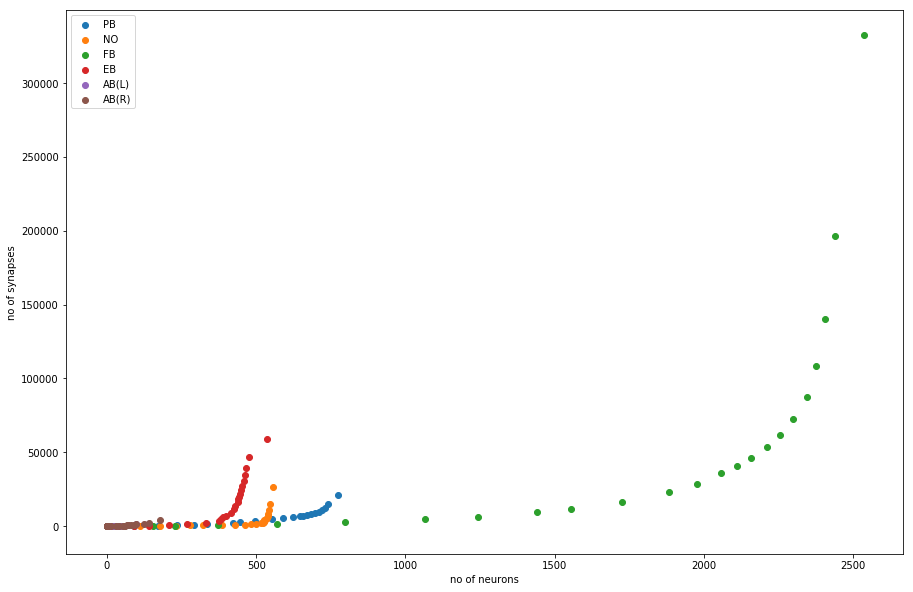

In [74]:

fig = plt.figure(figsize=(15,10))
for roi in hs.keys():
    plt.scatter(neurons[roi],synapses[roi],linewidths=1,label=roi)
plt.legend()
plt.ylabel('no of synapses')
plt.xlabel('no of neurons')
plt.show()

<h3>CX / combined plots: fh and components</h3>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data,calc_component_th

from fh import flow_hierarchy
from utils import conn2adj

In [40]:
def get_flow_hierarchy(rois,ths):
    hs = {roi:[] for roi in rois}
    ths_loc = {roi:[] for roi in rois}

    for roi in rois:
        for th in ths:
            path = os.path.join(conf.results_dir,'CX_study_th',f'th={th};roi={roi}.txt')
            if os.path.exists(path):
                with open(path,'r') as f:
                    res = f.read()
                    h,th = list(map(float,res.split(' ')))
                    hs[roi] += [h]
                    ths_loc[roi] += [th]
            else:
                hs[roi] += []
                ths_loc[roi] += []
                
    return hs,ths_loc

In [41]:
#CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
CX_rois = ['PB','NO','FB','EB']
#ths = [0,1,2,3,4,5,6,7,8,9,10,12,14,18,22,25,30,35,45,55,70,90,110]
ths = [i for i in range(150)]
ths_probe = [0,2,4,8,12,15,22,35,45,90,110]

neur_CX_split,conn_CX_split = {}, {}

for roi in CX_rois:
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi) 
    neur_CX_split[roi],conn_CX_split[roi] = n,conn

hs,ths_loc = get_flow_hierarchy(CX_rois,ths)
n_comp_th,e_comp_th,n_scomp_th,e_scomp_th = calc_component_th(conn_CX_split,CX_rois,ths)

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded


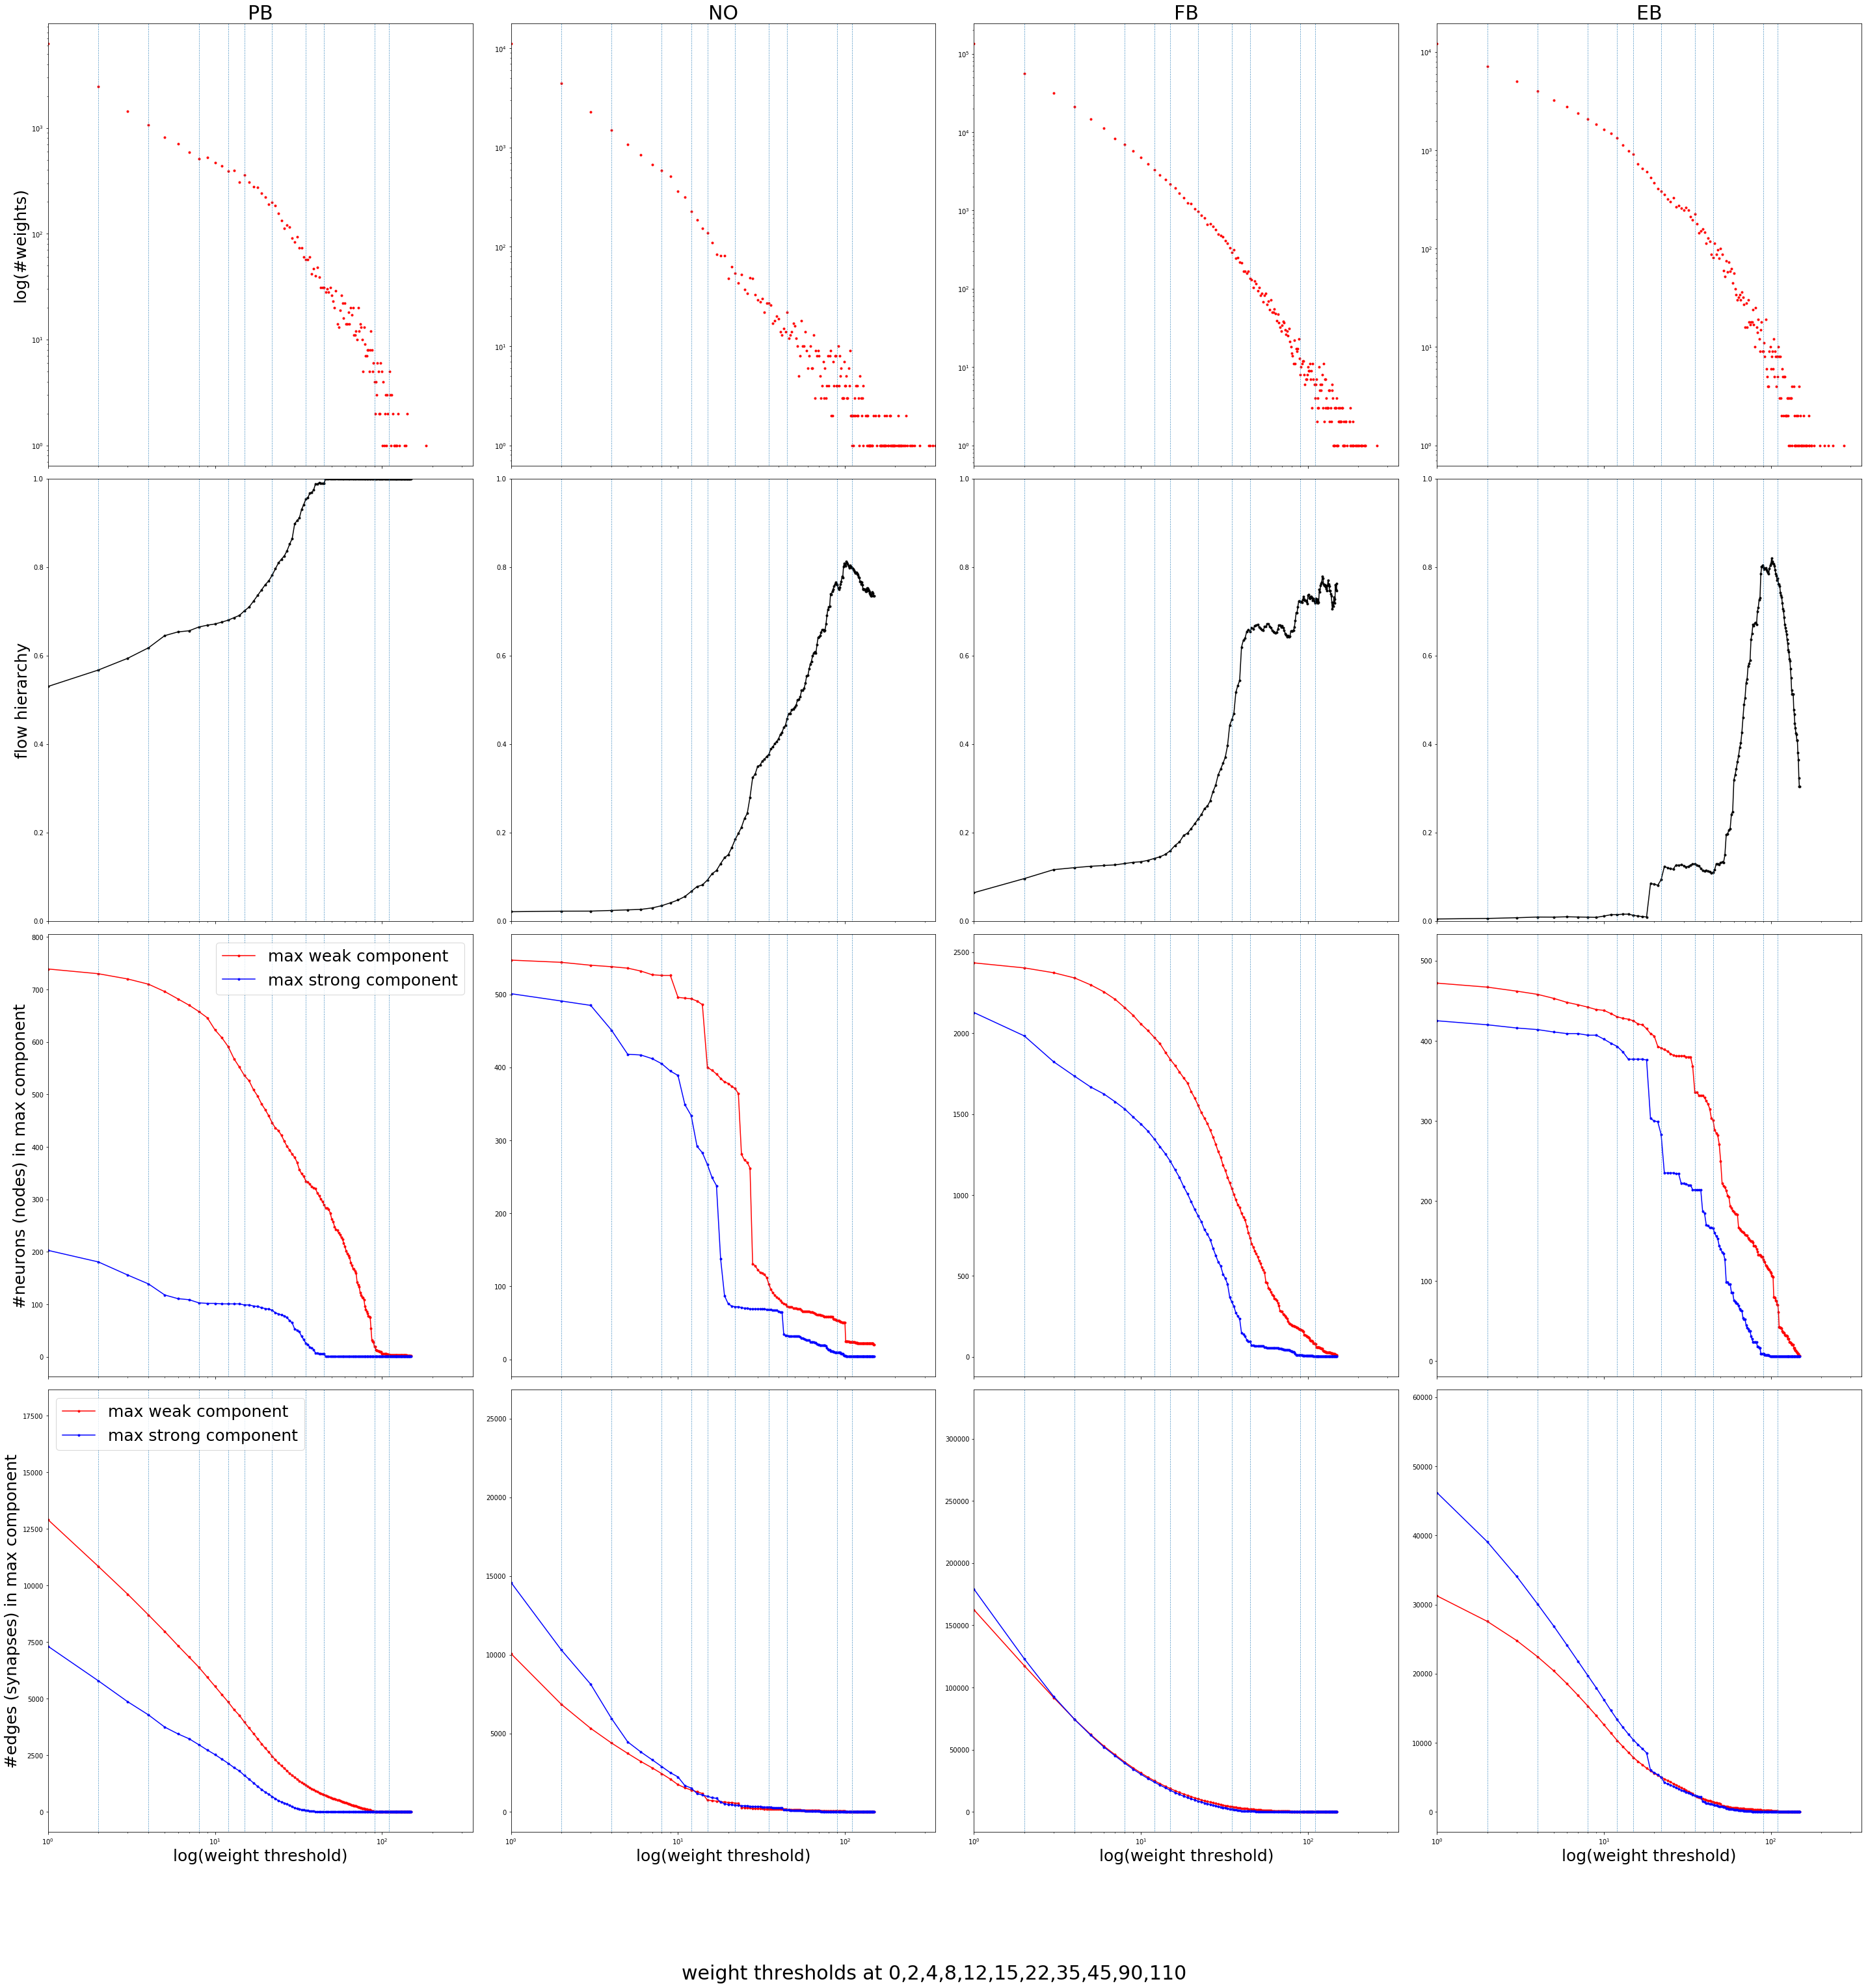

In [43]:

ncols=len(CX_rois)
nrows=4
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10*ncols,10*nrows),sharex=True)

# weights
first_col = True
ax = axs[0]

for i,roi in enumerate(CX_rois):
#     n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi)
    n,conn = neur_CX_split[roi], conn_CX_split[roi]

    #print(th,roi)
    #temp = conn[conn['weight']>th]
    vc = conn['weight'].value_counts()
    
    ax[i].plot(vc.index,vc.values,'r.',label=None)
    ax[i].set_title(roi,fontsize=30)
    if first_col: ax[i].set_ylabel('log(#weights)',fontsize=25)
    #ax[i].set_xlabel('log(weight)')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(ths[1],ths[-1]+200)
    
    for th in ths_probe:
        if first_col: #label only once
            ax[i].axvline(th,linestyle=':',linewidth=1)
        else:
            ax[i].axvline(th,linestyle=':',linewidth=1)
        
        
    first_col = False

# flow hierarchy
first_col = True    
ax = axs[1]

for i,roi in enumerate(hs.keys()):
    ax[i].plot(ths_loc[roi],hs[roi],'k.-',label=None)
    if first_col: ax[i].set_ylabel('flow hierarchy',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_ylim(0,1)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    
    first_col = False

# # max_component #neurons (nodes)
first_col = True    
ax = axs[2]

for i,roi in enumerate(CX_rois):

    ax[i].plot(ths,n_comp_th[roi],'r.-',label='max weak component')
    ax[i].plot(ths,n_scomp_th[roi],'b.-',label='max strong component')
    if first_col: ax[i].set_ylabel('#neurons (nodes) in max component',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    if first_col: ax[i].legend(fontsize=25)    
    first_col = False
# max_component #synapses (edges)
first_col = True    
ax = axs[3]

for i,roi in enumerate(CX_rois):

    ax[i].plot(ths,e_comp_th[roi],'r.-',label='max weak component')
    ax[i].plot(ths,e_scomp_th[roi],'b.-',label='max strong component')
    if first_col: ax[i].set_ylabel('#edges (synapses) in max component',fontsize=25)
    ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    if first_col: ax[i].legend(fontsize=25)
    first_col = False
    
# max_strong_component #neurons (nodes)
# first_col = True    
# ax = axs[4]

# for i,roi in enumerate(CX_rois):

#     ax[i].plot(ths,n_scomp_th[roi],'k.-',label=None)
#     if first_col: ax[i].set_ylabel('#nodes (neurons) in max strong component',fontsize=25)
#     #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
#     #ax[i].set_title(roi)
#     ax[i].set_xscale('log')
#     for th in ths_probe:
#         ax[i].axvline(th,linestyle=':',linewidth=1)
    
#     first_col = False
    
# max_strong_component #synapses (edges)
# first_col = True    
# ax = axs[5]

# for i,roi in enumerate(CX_rois):

#     ax[i].plot(ths,e_scomp_th[roi],'k.-',label=None)
#     if first_col: ax[i].set_ylabel('#edges (synapses) in max strong component',fontsize=25)
#     ax[i].set_xlabel('log(weight threshold)',fontsize=25)
#     #ax[i].set_title(roi)
#     ax[i].set_xscale('log')
#     for th in ths_probe:
#         ax[i].axvline(th,linestyle=':',linewidth=1)
    
#     first_col = False

#fig.legend(title='weight thresholds',loc='lower center')
fig.suptitle(''.join(['weight thresholds at ']+[str(th)+',' for th in ths_probe])[:-1],y=-0.05,fontsize=30)
plt.tight_layout()
plt.show()

<h3>CX / max comp method comparison</h3>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data,calc_component_th

from fh import flow_hierarchy
from utils import conn2adj

In [29]:
def get_flow_hierarchy_var(rois,ths,var):
    hs = {roi:[] for roi in rois}
    ths_loc = {roi:[] for roi in rois}
    maxcomp_sizes = {roi:[] for roi in rois}
    
    for roi in rois:
        for th in ths:
            path = os.path.join(conf.results_dir,'CX_study_th_maxcomp',f'var={var};th={th};roi={roi}.txt')
            if os.path.exists(path):
                with open(path,'r') as f:
                    res = f.read()
                    h,th,maxcomp_size = list(map(float,res.split(' ')))
                    hs[roi] += [h]
                    ths_loc[roi] += [th]
                    maxcomp_sizes[roi] += [maxcomp_size]
            else:
                hs[roi] += []
                ths_loc[roi] += []
                maxcomp_sizes[roi] += []
                
    return hs,ths_loc,maxcomp_sizes

In [30]:
#CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
CX_rois = ['PB','NO','FB','EB']
#ths = [0,1,2,3,4,5,6,7,8,9,10,12,14,18,22,25,30,35,45,55,70,90,110]
ths = [i for i in range(150)]
ths_probe = [0,2,4,8,12,15,22,35,45,90,110]

neur_CX_split,conn_CX_split = {}, {}

for roi in CX_rois:
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi) 
    neur_CX_split[roi],conn_CX_split[roi] = n,conn

hs = {var:{} for var in range(4)}
ths_loc = {var:{} for var in range(4)}
maxcomp_sizes = {var:{} for var in range(4)}
for var in range(4):
    hs[var],ths_loc[var],maxcomp_sizes[var] = get_flow_hierarchy_var(CX_rois,ths,var)
    
    #n_comp_th,e_comp_th,n_scomp_th,e_scomp_th = calc_component_th(conn_CX_split,CX_rois,ths)

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded


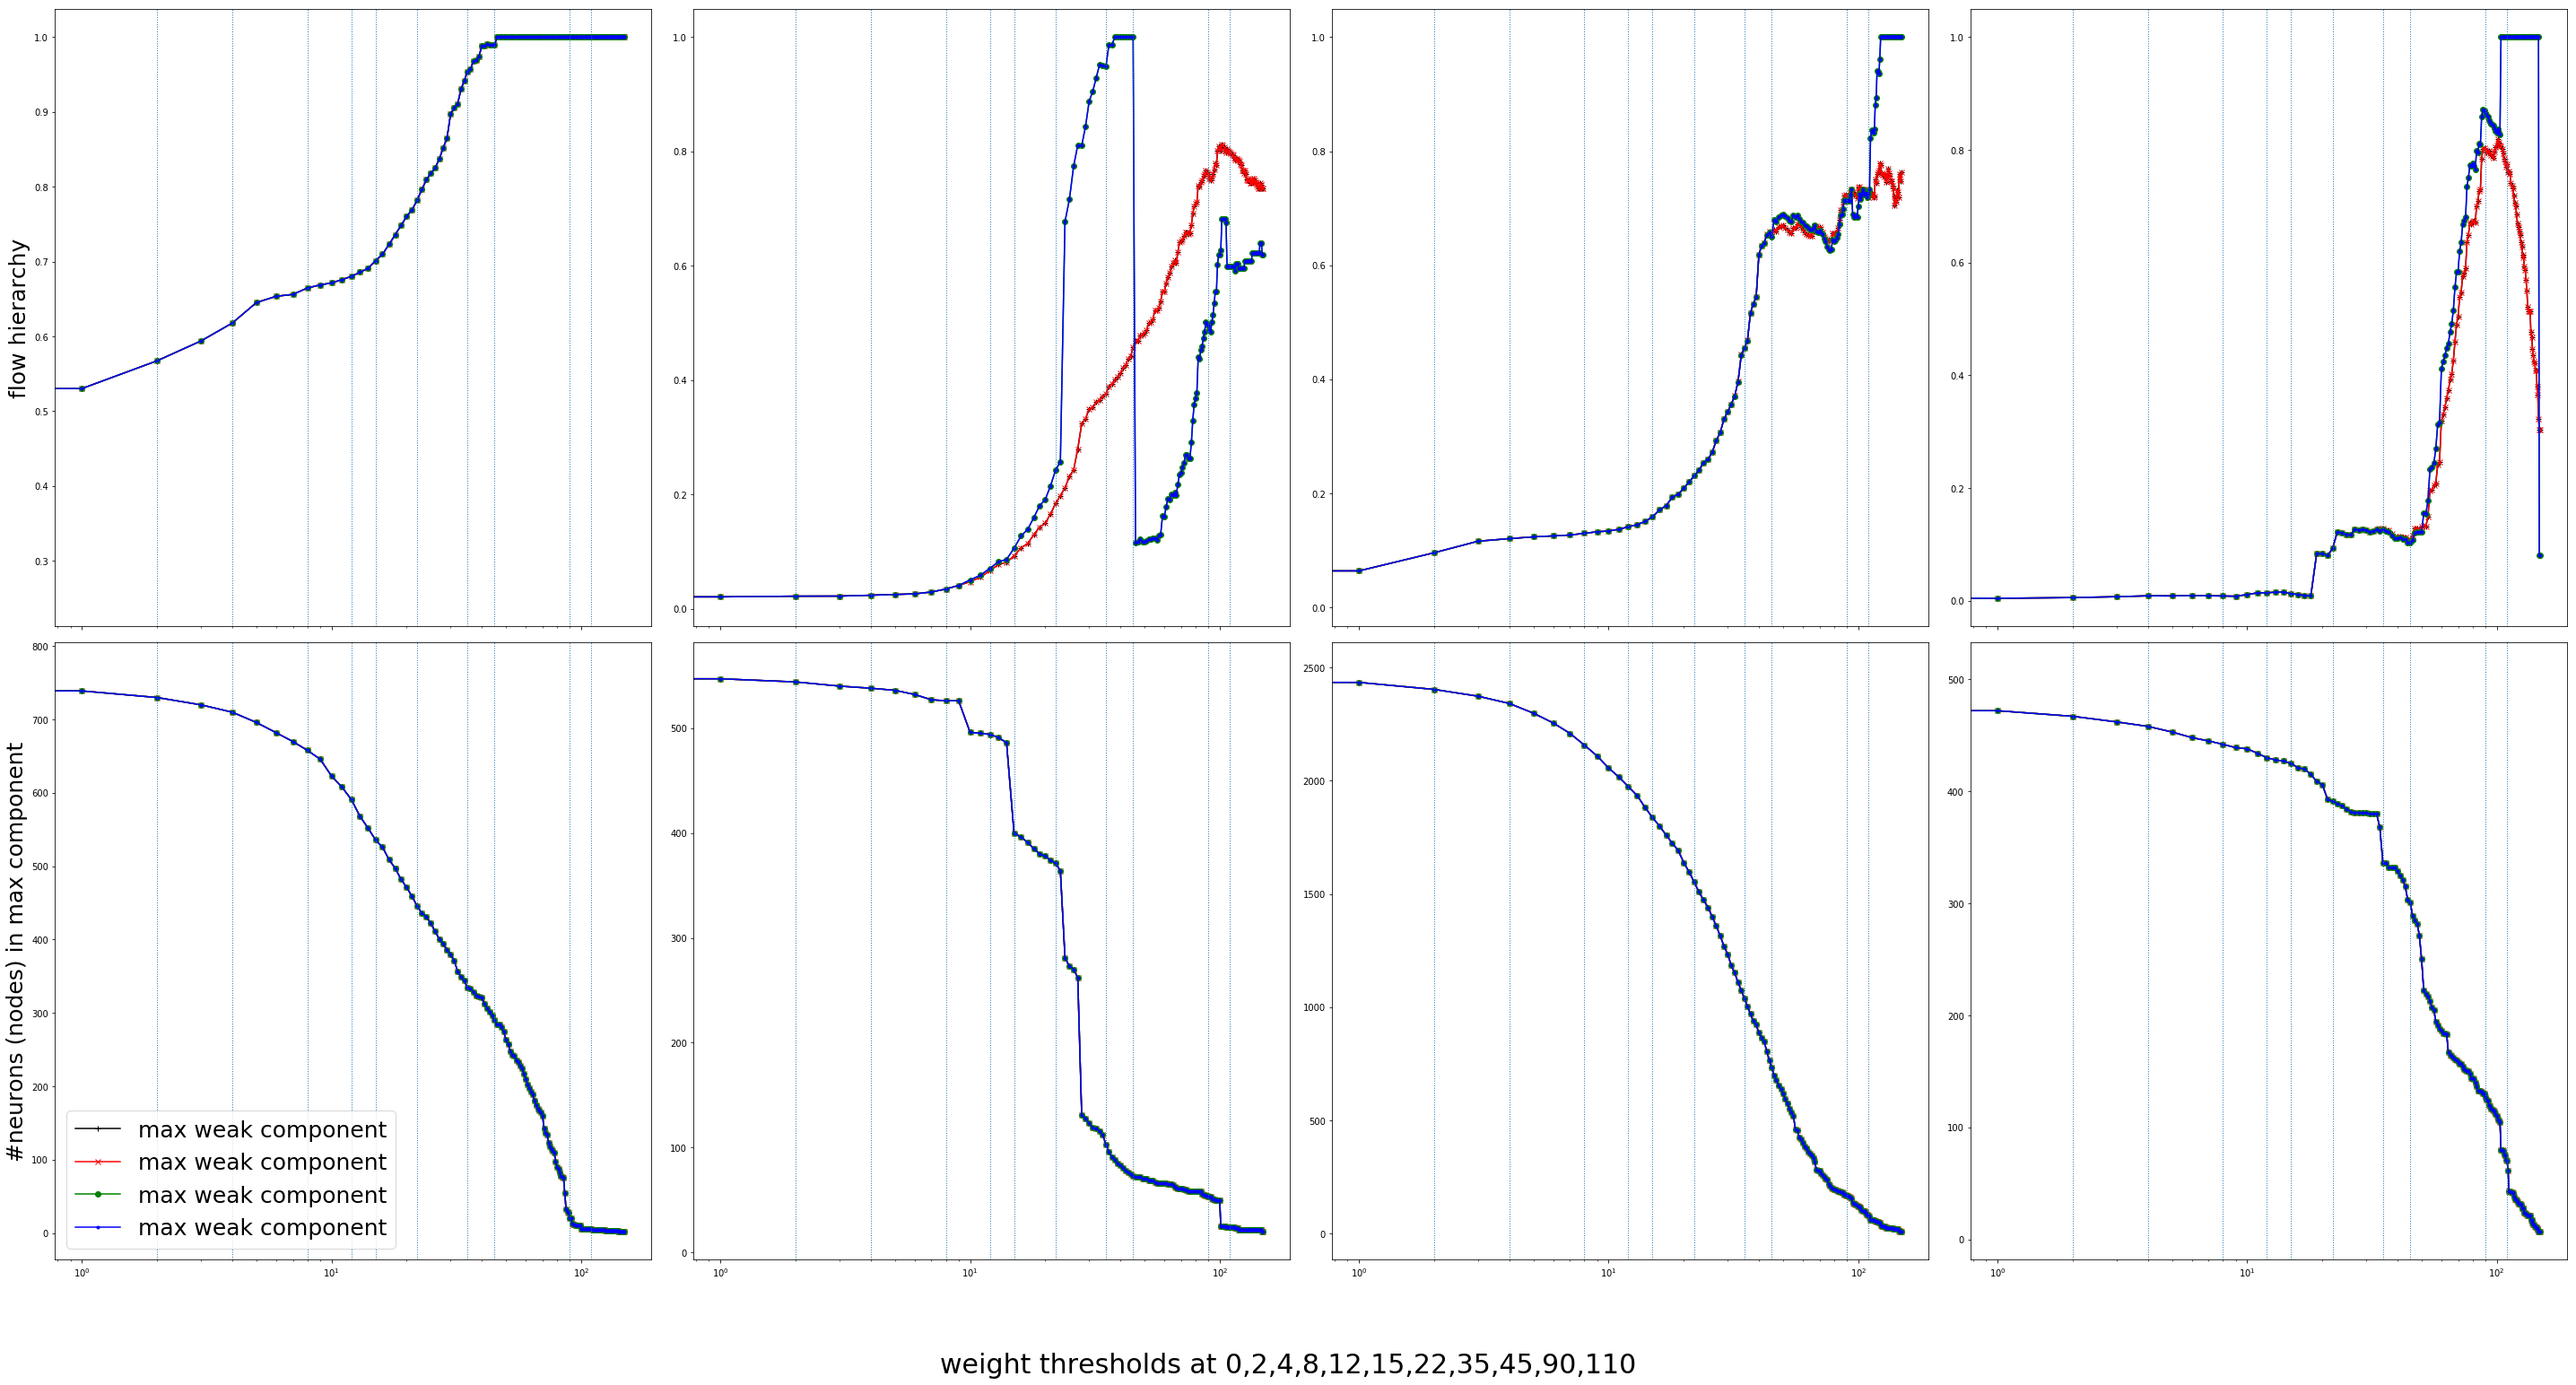

In [36]:

ncols=len(CX_rois)
nrows=2
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10*ncols,10*nrows),sharex=True)

# flow hierarchy
first_col = True    
ax = axs[0]

styles={0:'k+-',1:'rx-',2:'go-',3:'b.-'}

for i,roi in enumerate(CX_rois):
    for var in range(4):
        ax[i].plot(ths_loc[var][roi],hs[var][roi],styles[var],label=None)
    if first_col: ax[i].set_ylabel('flow hierarchy',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    
    first_col = False

# # max_component #neurons (nodes)
first_col = True    
ax = axs[1]

for i,roi in enumerate(CX_rois):
    for var in range(4):
        ax[i].plot(ths_loc[var][roi],maxcomp_sizes[var][roi],styles[var],label='max weak component')
        #ax[i].plot(ths,n_scomp_th[roi],'b.-',label='max strong component')
    if first_col: ax[i].set_ylabel('#neurons (nodes) in max component',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    if first_col: ax[i].legend(fontsize=25)    
    first_col = False

fig.suptitle(''.join(['weight thresholds at ']+[str(th)+',' for th in ths_probe])[:-1],y=-0.05,fontsize=30)
plt.tight_layout()
plt.show()


<h3>CX / fh total vs. fh maxcomp</h3>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data,calc_component_th

from fh import flow_hierarchy
from utils import conn2adj

In [9]:
def get_flow_hierarchy(rois,ths):
    hs = {roi:[] for roi in rois}
    ths_loc = {roi:[] for roi in rois}

    for roi in rois:
        for th in ths:
            path = os.path.join(conf.results_dir,'CX_study_th',f'th={th};roi={roi}.txt')
            if os.path.exists(path):
                with open(path,'r') as f:
                    res = f.read()
                    h,th = list(map(float,res.split(' ')))
                    hs[roi] += [h]
                    ths_loc[roi] += [th]
            else:
                hs[roi] += []
                ths_loc[roi] += []
        assert len(ths_loc[roi])== len(hs[roi]), 'data size mismatch'       
    return hs,ths_loc

def get_flow_hierarchy_maxcomp(rois,ths):
    hs = {roi:[] for roi in rois}
    maxcomp_sizes = {roi:[] for roi in rois}
    ths_loc = {roi:[] for roi in rois}

    for roi in rois:
        for th in ths:
            path = os.path.join(conf.results_dir,'CX_study_th_maxcomp',f'th={th};roi={roi}.txt')
            if os.path.exists(path):
                with open(path,'r') as f:
                    res = f.read()
                    h,th,maxcomp_size = list(map(float,res.split(' ')))
                    hs[roi] += [h]
                    ths_loc[roi] += [th]
                    maxcomp_sizes[roi] += [maxcomp_size]
            else:
                hs[roi] += []
                ths_loc[roi] += []
                maxcomp_sizes[roi] += []   
    
        assert len(ths_loc[roi])== len(hs[roi]) == len(maxcomp_sizes[roi]), 'data size mismatch'
    return hs,ths_loc,maxcomp_sizes

In [10]:
CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
#ths = [0,1,2,3,4,5,6,7,8,9,10,12,14,18,22,25,30,35,45,50,52,54,55,57,59,62,65,70,90,110]
ths = [i for i in range(150)]
ths_probe = [0,2,4,8,12,15,22,35,45,90,110]

# neur_CX_split,conn_CX_split = {}, {}

# for roi in CX_rois:
#     n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi) 
#     neur_CX_split[roi],conn_CX_split[roi] = n,conn

h_maxcomp_s,ths_loc,maxcomp_sizes = get_flow_hierarchy_maxcomp(CX_rois,ths)
hs,ths_loc = get_flow_hierarchy(CX_rois,ths)
#n_comp_th,e_comp_th,n_scomp_th,e_scomp_th = calc_component_th(conn_CX_split,CX_rois,ths)

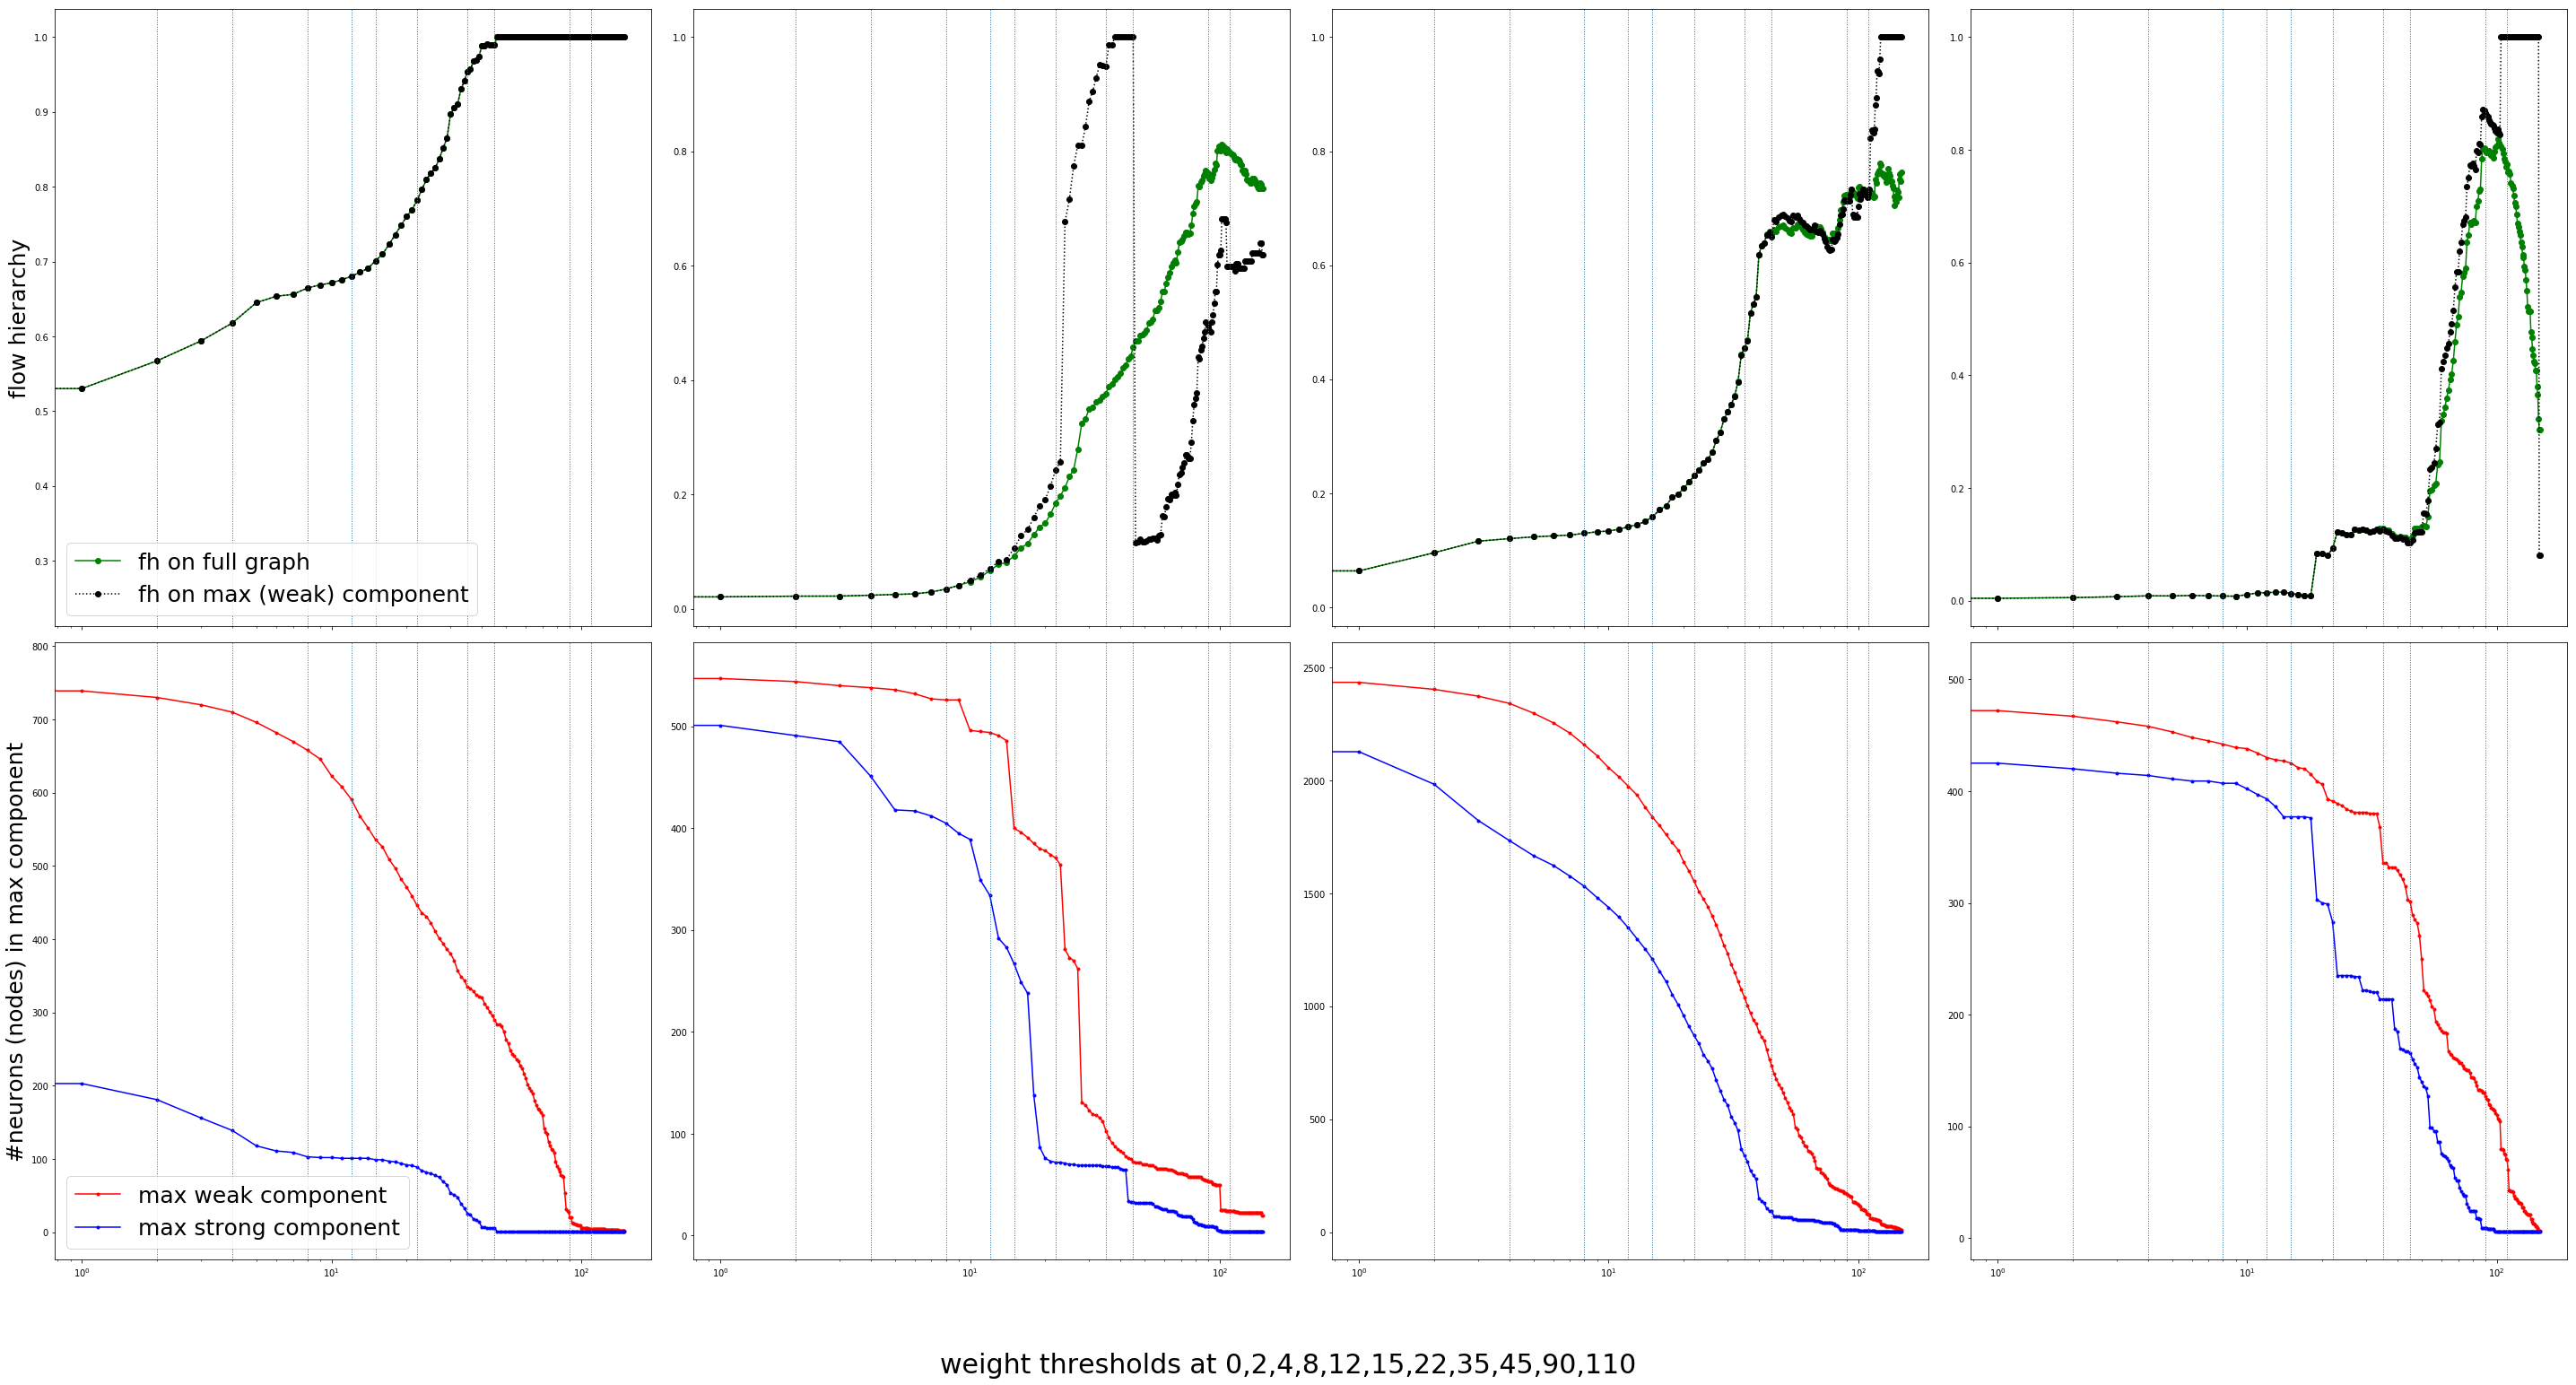

In [15]:
CX_rois_restricted = ['PB','NO','FB','EB']

CX_rois = CX_rois_restricted

ncols=len(CX_rois)
nrows=2
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(10*ncols,10*nrows),sharex=True)

# weights
# first_col = True
# ax = axs[0]

# for i,roi in enumerate(CX_rois):
# #     n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi)
#     n,conn = neur_CX_split[roi], conn_CX_split[roi]

#     #print(th,roi)
#     #temp = conn[conn['weight']>th]
#     vc = conn['weight'].value_counts()
    
#     ax[i].plot(vc.index,vc.values,'ko',label=None)
#     ax[i].set_title(roi,fontsize=30)
#     if first_col: ax[i].set_ylabel('log(#weights)',fontsize=25)
#     #ax[i].set_xlabel('log(weight)')
#     ax[i].set_yscale('log')
#     ax[i].set_xscale('log')
#     ax[i].set_xlim(ths[1],ths[-1]+200)
    
#     for th in ths_probe:
#         if first_col: #label only once
#             ax[i].axvline(th,linestyle=':',linewidth=1)
#         else:
#             ax[i].axvline(th,linestyle=':',linewidth=1)
        
        
#     first_col = False

# flow hierarchy
first_col = True    
ax = axs[0]

for i,roi in enumerate(CX_rois):
    ax[i].plot(ths_loc[roi],hs[roi],'go-',label='fh on full graph')
    ax[i].plot(ths_loc[roi],h_maxcomp_s[roi],'ko:',label='fh on max (weak) component')
    if first_col: ax[i].set_ylabel('flow hierarchy',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    if first_col: ax[i].legend(fontsize=25)
    first_col = False

# # max_component #neurons (nodes)
first_col = True    
ax = axs[1]

for i,roi in enumerate(CX_rois):

    ax[i].plot(ths_loc[roi],maxcomp_sizes[roi],'r.-',label='max weak component')
    ax[i].plot(ths,n_scomp_th[roi],'b.-',label='max strong component')
    if first_col: ax[i].set_ylabel('#neurons (nodes) in max component',fontsize=25)
    #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
    #ax[i].set_title(roi)
    ax[i].set_xscale('log')
    for th in ths_probe:
        ax[i].axvline(th,linestyle=':',linewidth=1)
    if first_col: ax[i].legend(fontsize=25)    
    first_col = False
    
# max_component #synapses (edges)
# first_col = True    
# ax = axs[3]

# for i,roi in enumerate(CX_rois):

#     ax[i].plot(ths,e_comp_th[roi],'r.-',label='weak component')
#     ax[i].plot(ths,e_scomp_th[roi],'b.-',label='strong component')
#     if first_col: ax[i].set_ylabel('#edges (synapses) in max component',fontsize=25)
#     ax[i].set_xlabel('log(weight threshold)',fontsize=25)
#     #ax[i].set_title(roi)
#     ax[i].set_xscale('log')
#     for th in ths_probe:
#         ax[i].axvline(th,linestyle=':',linewidth=1)
#     if first_col: ax[i].legend(fontsize=25)
#     first_col = False
    
# max_strong_component #neurons (nodes)
# first_col = True    
# ax = axs[4]

# for i,roi in enumerate(CX_rois):

#     ax[i].plot(ths,n_scomp_th[roi],'k.-',label=None)
#     if first_col: ax[i].set_ylabel('#nodes (neurons) in max strong component',fontsize=25)
#     #ax[i].set_xlabel('log(weight threshold)',fontsize=25)
#     #ax[i].set_title(roi)
#     ax[i].set_xscale('log')
#     for th in ths_probe:
#         ax[i].axvline(th,linestyle=':',linewidth=1)
    
#     first_col = False
    
# max_strong_component #synapses (edges)
# first_col = True    
# ax = axs[5]

# for i,roi in enumerate(CX_rois):

#     ax[i].plot(ths,e_scomp_th[roi],'k.-',label=None)
#     if first_col: ax[i].set_ylabel('#edges (synapses) in max strong component',fontsize=25)
#     ax[i].set_xlabel('log(weight threshold)',fontsize=25)
#     #ax[i].set_title(roi)
#     ax[i].set_xscale('log')
#     for th in ths_probe:
#         ax[i].axvline(th,linestyle=':',linewidth=1)
    
#     first_col = False

#fig.legend(title='weight thresholds',loc='lower center')
fig.suptitle(''.join(['weight thresholds at ']+[str(th)+',' for th in ths_probe])[:-1],y=-0.05,fontsize=30)
plt.tight_layout()
plt.show()

<h3>CX(PB) / check whether max strong comp lies within max comp as we vary th</h3>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data,calc_component_th

from CX_utils import restrict_th,restrict_max_comp,find_max_comp_neurons,find_max_scomp_neurons

from fh import flow_hierarchy
from utils import conn2adj

In [76]:
CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
#CX_rois = ['PB']
#ths = [0,1,2,3,4,5,6,7,8,9,10,12,14,18,22,25,30,35,45,55,70,90,110]
ths = [i for i in range(150)]
ths_probe = [0,2,4,8,12,15,22,35,45,90,110]

neur_CX_split,conn_CX_split = {}, {}

for roi in CX_rois:
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi) 
    neur_CX_split[roi],conn_CX_split[roi] = n,conn

hs,ths_loc = get_flow_hierarchy(CX_rois,ths)
#n_comp_th,e_comp_th,n_scomp_th,e_scomp_th = calc_component_th(conn_CX_split,CX_rois,ths)

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(L)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(R)
dataset already downloaded


In [91]:
conn0 = conn_CX_split['PB']

for th in ths:
    conn = restrict_th(conn0,th)
    maxcomp = find_max_comp_neurons(conn)
    maxscomp = find_max_scomp_neurons(conn)
    print(len(maxcomp),len(maxscomp),len(set.intersection(maxcomp,maxscomp)))
    if len(maxscomp) != len(set.intersection(maxcomp,maxscomp)):
        print(f'mismatch at {th}') 
        break
    

767 383 383
739 203 203
730 181 181
720 156 156
710 139 139
696 118 118
682 111 111
670 109 109
658 103 103
646 102 102
623 102 102
608 101 101
591 101 101
568 101 101
552 101 101
536 99 99
526 99 99
509 97 97
497 96 96
482 94 94
471 92 92
459 91 91
446 89 89
436 84 84
431 82 82
422 80 80
411 78 78
401 75 75
394 69 69
386 65 65
380 53 53
371 51 51
357 48 48
349 39 39
344 33 33
335 26 26
333 24 24
329 18 18
324 17 17
322 14 14
321 7 7
312 7 7
307 6 6
301 6 6
296 6 6
290 6 6
284 1 1
284 1 1
281 1 1
274 1 1
263 1 1
258 1 1
248 1 1
243 1 1
241 1 1
236 1 1
233 1 1
228 1 1
224 1 1
217 1 1
210 1 1
202 1 1
197 1 1
193 1 1
189 1 1
180 1 1
174 1 1
169 1 1
167 1 1
164 1 1
160 1 1
142 1 1
137 1 1
134 1 1
123 1 1
118 1 1
114 1 1
112 1 1
109 1 1
97 1 1
90 1 1
87 1 1
83 1 1
78 1 1
77 1 1
75 1 1
54 1 1
32 1 0
mismatch at 87


In [92]:
conn0 = conn_CX_split['NO']

for th in ths:
    conn = restrict_th(conn0,th)
    maxcomp = find_max_comp_neurons(conn)
    maxscomp = find_max_scomp_neurons(conn)
    print(len(maxcomp),len(maxscomp),len(set.intersection(maxcomp,maxscomp)))
    if len(maxscomp) != len(set.intersection(maxcomp,maxscomp)):
        print(f'mismatch at {th}') 
        break
    

555 518 518
547 501 501
544 491 491
540 485 485
538 451 451
536 418 418
532 417 417
527 412 412
526 405 405
526 395 395
496 389 389
495 349 349
494 334 334
491 292 292
486 283 283
400 267 267
396 249 249
391 238 238
385 138 138
380 87 87
378 76 76
374 73 73
371 72 72
364 72 72
281 71 0
mismatch at 24


In [93]:
conn0 = conn_CX_split['FB']

for th in ths:
    conn = restrict_th(conn0,th)
    maxcomp = find_max_comp_neurons(conn)
    maxscomp = find_max_scomp_neurons(conn)
    print(len(maxcomp),len(maxscomp),len(set.intersection(maxcomp,maxscomp)))
    if len(maxscomp) != len(set.intersection(maxcomp,maxscomp)):
        print(f'mismatch at {th}') 
        break
    

2487 2342 2342
2434 2127 2127
2403 1983 1983
2373 1823 1823
2341 1734 1734
2298 1667 1667
2255 1624 1624
2209 1576 1576
2157 1531 1531
2109 1481 1481
2056 1438 1438
2016 1395 1395
1974 1347 1347
1935 1299 1299
1882 1254 1254
1837 1208 1208
1800 1156 1156
1760 1109 1109
1724 1052 1052
1692 1007 1007
1639 958 958
1598 910 910
1554 871 871
1509 835 835
1474 786 786
1441 758 758
1400 724 724
1359 672 672
1315 628 628
1269 587 587
1234 562 562
1184 511 511
1152 485 485
1110 450 450
1075 369 369
1040 339 339
1004 313 313
970 272 272
940 252 252
923 235 235
887 148 148
865 139 139
848 128 128
807 105 105
767 95 95
736 94 94
700 70 70
679 70 70
655 69 69
639 67 67
618 67 67
594 67 67
576 67 67
552 67 67
537 67 67
521 60 60
462 60 60
456 56 56
426 56 56
419 56 56
401 56 56
385 56 56
378 56 56
362 55 55
355 55 55
347 55 55
334 55 55
317 51 51
283 51 51
280 51 51
279 47 47
266 47 47
261 44 44
252 44 44
245 44 44
238 44 44
219 44 44
210 44 44
205 41 41
201 37 37
197 37 37
194 32 32
193 32 32
189 2

In [94]:
conn0 = conn_CX_split['EB']

for th in ths:
    conn = restrict_th(conn0,th)
    maxcomp = find_max_comp_neurons(conn)
    maxscomp = find_max_scomp_neurons(conn)
    print(len(maxcomp),len(maxscomp),len(set.intersection(maxcomp,maxscomp)))
    if len(maxscomp) != len(set.intersection(maxcomp,maxscomp)):
        print(f'mismatch at {th}') 
        break
    

508 438 438
472 425 425
467 420 420
462 416 416
458 414 414
453 411 411
448 409 409
445 409 409
442 407 407
439 407 407
438 402 402
434 397 397
430 393 393
428 386 386
427 377 377
425 377 377
421 377 377
420 377 377
415 376 376
409 303 303
406 300 300
393 299 299
391 283 283
389 235 235
387 235 235
384 235 235
382 235 235
381 234 234
381 234 234
381 222 222
381 222 222
380 221 221
380 220 220
380 220 220
368 214 214
336 214 214
336 214 214
332 214 214
332 214 214
332 187 187
329 185 185
325 170 170
321 169 169
315 167 167
303 167 167
301 166 166
289 160 160
285 156 156
282 153 153
271 144 144
250 140 140
222 136 136
219 134 134
217 127 127
213 99 99
207 99 99
205 96 96
194 96 96
191 86 86
188 86 86
186 76 76
184 74 74
184 73 73
183 72 72
167 69 69
165 65 65
164 64 64
162 63 63
161 54 54
160 52 52
158 52 52
157 45 45
157 42 42
154 40 40
152 38 38
151 38 38
150 31 31
150 28 28
148 24 24
144 24 24
144 24 24
143 24 24
140 24 24
137 18 18
133 18 18
133 17 17
133 17 17
132 9 0
mismatch at 87

<h3>CX / connected components and strongly connected components</h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx

from neuprint import Client

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean

from fh.flow_hierarchy import hnx
from utils import conn2adj
from config import conf


In [3]:
neur_CX_split,conn_CX_split = {}, {}
CX_rois = ['PB','NO','FB','EB','AB(L)','AB(R)']
for roi in CX_rois:
    n,conn = fetch_adjacency(adjpath='datasets/noncropped_traced_'+roi) 
    neur_CX_split[roi],conn_CX_split[roi] = n,conn

dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_NO
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_FB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_EB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(L)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_AB(R)
dataset already downloaded


In [200]:
temp = conn.copy()
G = nx.DiGraph()
G.add_weighted_edges_from([tuple(v) for v in temp[['bodyId_pre','bodyId_post','weight']].values])

In [201]:
components = [G.subgraph(c) for c in nx.strongly_connected_components(G)]
n_comp = len(components)
print('connected components of the original graph', n_comp)
print()

for i in range(n_comp):
    nodesi = list(components[i].nodes)
    edges = components[i].number_of_edges()
    print('component {} nodes {} edges {:}'.format(i, len(nodesi), edges))
print()

connected components of the original graph 67

component 0 nodes 1 edges 0
component 1 nodes 1 edges 0
component 2 nodes 1 edges 0
component 3 nodes 1 edges 0
component 4 nodes 1 edges 0
component 5 nodes 1 edges 0
component 6 nodes 1 edges 0
component 7 nodes 1 edges 0
component 8 nodes 1 edges 0
component 9 nodes 1 edges 0
component 10 nodes 1 edges 0
component 11 nodes 1 edges 0
component 12 nodes 1 edges 0
component 13 nodes 1 edges 0
component 14 nodes 1 edges 0
component 15 nodes 1 edges 0
component 16 nodes 1 edges 0
component 17 nodes 1 edges 0
component 18 nodes 1 edges 0
component 19 nodes 1 edges 0
component 20 nodes 1 edges 0
component 21 nodes 1 edges 0
component 22 nodes 1 edges 0
component 23 nodes 1 edges 0
component 24 nodes 1 edges 0
component 25 nodes 1 edges 0
component 26 nodes 1 edges 0
component 27 nodes 1 edges 0
component 28 nodes 1 edges 0
component 29 nodes 1 edges 0
component 30 nodes 1 edges 0
component 31 nodes 1 edges 0
component 32 nodes 1 edges 0
compon

In [203]:
G_und = G.to_undirected()
components = [G_und.subgraph(c) for c in nx.connected_components(G_und)]
n_comp = len(components)
print('connected components of the original graph', n_comp)
print()

for i in range(n_comp):
    nodesi = list(components[i].nodes)
    edges = components[i].number_of_edges()
    print('component {} nodes {} edges {:}'.format(i, len(nodesi), edges))
print()

connected components of the original graph 1

component 0 nodes 176 edges 2865



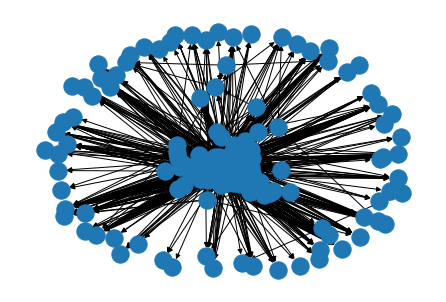

In [191]:
nx.drawing.nx_pylab.draw(g)

In [ ]:
g = nx.DiGraph(A)
hdegree = nx.flow_hierarchy(g,weight='weight')

In [ ]:


Aorg = np.zeros_like(adj)
Aorg[adj>0] = 1
G = nx.from_numpy_array(Aorg, create_using=nx.Graph)

# components in original graph

components = [G.subgraph(c) for c in nx.connected_components(G)]
n_comp = len(components)
print('connected components of the original graph', n_comp)
print()

for i in range(n_comp):
    nodesi = list(components[i].nodes)
    edges = components[i].number_of_edges()
    print('component {} nodes {} edges {:}'.format(i, len(nodesi), edges))

<h1>other</h1>

In [8]:
#establish relation roi -> main_roi

from neuprint import Client,fetch_roi_hierarchy

c = Client('neuprint.janelia.org', 'hemibrain:v1.1')
g = fetch_roi_hierarchy(mark_primary=False,include_subprimary=True,format='nx')

def find_main_roi(roi):
    pred = list(g.predecessors(roi))[0]
    if pred!='hemibrain':
        return find_main_roi(pred)
    else:
        return roi

df['main_roi'] = df['roi'].apply(func=find_main_roi)

NameError: name 'df' is not defined